In [1]:
import glob
import torch


In [2]:
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '7'#H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '8'


#H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '7'
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '6'

#H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '6'
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '5'

exp_path_img64= '/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2/figs/baselineF/name(bbbcHumanMCF7cellsW4)@rotation_lambda(10000.0)@lambda_scale_factor(4)@T(4)@lr_H(1.0)@img_size(64)@num_samples_train(3000)@batch_size_train(32)'
exp_path_img256= '/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2/figs/baselineF/name(bbbcHumanMCF7cellsW4)@rotation_lambda(10000.0)@lambda_scale_factor(4)@T(4)@lr_H(1.0)@img_size(256)@num_samples_train(3000)@batch_size_train(32)'

exp_dir= exp_path_img256
glob.glob(f'{exp_dir}/save_special/*.pth')

['/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2/figs/baselineF/name(bbbcHumanMCF7cellsW4)@rotation_lambda(10000.0)@lambda_scale_factor(4)@T(4)@lr_H(1.0)@img_size(256)@num_samples_train(3000)@batch_size_train(32)/save_special/latest_model.pth']

In [3]:
model_dir = glob.glob(f'{exp_dir}/save_special/*.pth')[0]

In [4]:
model_info= torch.load(model_dir)
cfg= model_info['cfg']

decoder_upsample_state_dict= model_info['decoder_upsample']
decoder_state_dict= model_info['decoder']
model_H_state_dict= model_info['model_H']
m = model_info['m']
epoch = model_info['epoch']

In [5]:
import sys
sys.path.append('../DabbaMu-DEEP-TFM/aim2')

import torch
import glob
from torch import nn
import shutil
import os
from contextlib import redirect_stdout
from defaults import get_cfg_defaults

from modules.models.preprocess_H_weights import * #ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom
from modules.kernels import *

from modules.datasets import *
from modules.data_utils import return_dataloaders

from modules.train_utils.segmentation import train

from modules.models.forward_model import modelA_class
from modules.models.forward_H import modelH_class
from modules.models.decoder import *
from modules.models.decoder_upsampling_nets import *
from modules.models.decoder_upsampling_nets_experimental import *
from modules.models.decoder_support_blocks import conv_bn_block
from modules.m_inc_procs import *

from modules.models.lambdat_yt_skips import *

#general params
torch_seed= cfg.GENERAL.torch_seed
device = 'cpu'
cfg.merge_from_list(['GENERAL.device', device])

save_dir= cfg.GENERAL.save_dir

#dataset params
get_dataset_func= eval(cfg.DATASET.name)
img_size= cfg.DATASET.img_size
num_samples_train= cfg.DATASET.num_samples_train
delta=cfg.DATASET.delta
batch_size_train= cfg.DATASET.batch_size_train
img_channels= cfg.DATASET.img_channels

# train params:
epochs=cfg.TRAIN.epochs
m_inc_proc =  eval(cfg.TRAIN.m_inc_proc)
show_results_epoch= cfg.TRAIN.show_results_epoch
train_model_iter= cfg.TRAIN.train_model_iter
train_H_iter= cfg.TRAIN.train_H_iter
criterion= eval(cfg.TRAIN.criterion) # defined below after defining models
classifier=cfg.TRAIN.classifier
rescale_for_classifier=cfg.TRAIN.rescale_for_classifier

## params to H:
T= cfg.MODEL.MODEL_H.T
H_weight_preprocess= eval(cfg.MODEL.MODEL_H.H_weight_preprocess)
H_init = cfg.MODEL.MODEL_H.H_init
initialization_bias= cfg.MODEL.MODEL_H.initialization_bias
H_activation= eval(cfg.MODEL.MODEL_H.H_activation)
lr_H= cfg.MODEL.MODEL_H.lr_H

## params to A
sPSF= eval(cfg.MODEL.MODEL_A.sPSF)
exPSF= eval(cfg.MODEL.MODEL_A.exPSF)

noise=cfg.MODEL.MODEL_A.noise
lambda_scale_factor=cfg.MODEL.MODEL_A.lambda_scale_factor # downsample
rotation_lambda=cfg.MODEL.MODEL_A.rotation_lambda
shift_lambda_real=cfg.MODEL.MODEL_A.shift_lambda_real

readnoise_std=cfg.MODEL.MODEL_A.readnoise_std

## decoder params:
decoder_name= eval(cfg.MODEL.MODEL_DECODER.name)
upsampling_net_name = eval(cfg.MODEL.MODEL_DECODER.upsample_net)
custom_upsampling_bias= cfg.MODEL.MODEL_DECODER.custom_upsampling_bias
decoder_upsample_init_method= cfg.MODEL.MODEL_DECODER.upsample_net_init_method
channel_list=cfg.MODEL.MODEL_DECODER.channel_list
lr_decoder= cfg.MODEL.MODEL_DECODER.lr_decoder
last_activation=cfg.MODEL.MODEL_DECODER.last_activation #'sigmoid'

connect_forward_inverse= eval(cfg.MODEL.MODEL_DECODER.connect_forward_inverse)
print(f'skip connection between FORWARD and INVERSE models :: {cfg.MODEL.MODEL_DECODER.connect_forward_inverse}')
########################################################################

if lr_H==0:enable_train= False
else:enable_train=True

skip connection between FORWARD and INVERSE models :: no_skips


In [6]:
modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, 
                          device = device, 
                          initialization_bias=initialization_bias, 
                          activation = H_activation, init_method= H_init, 
                          enable_train=enable_train, lambda_scale_factor= lambda_scale_factor).to(device)
    
modelA= modelA_class(sPSF= sPSF.to(device), exPSF= exPSF.to(device), noise=noise, device = device, 
                         scale_factor=lambda_scale_factor, rotation_lambda=rotation_lambda, 
                         shift_lambda_real= shift_lambda_real,
                         readnoise_std= readnoise_std)
    
if T!=1:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T//2, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T//2, out_channels= T, kernel_size= 3, padding= 1, stride=1))
else:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T, out_channels= T, kernel_size= 3, padding= 1, stride=1))

decoder_upsample_net= upsampling_net_name(lambda_scale_factor= lambda_scale_factor, T= T, recon_img_size= img_size, init_method= decoder_upsample_init_method, Ht= modelH(m=1).detach(), custom_upsampling_bias= custom_upsampling_bias, upsample_postproc_block= upsample_postproc_block)
    
if decoder_upsample_net.__class__.__bases__[0]== nn.modules.module.Module:
    decoder_upsample_net= decoder_upsample_net.to(device)

decoder= decoder_name(T, img_size, img_channels, channel_list, last_activation).to(device)


In [7]:
decoder_upsample_net.load_state_dict(decoder_upsample_state_dict)
decoder.load_state_dict(decoder_state_dict)
modelH.load_state_dict(model_H_state_dict)

decoder_upsample_net.eval()
decoder.eval()
modelH.eval()

print('loading successful !!!')

loading successful !!!


total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 3000 | 100 | 100


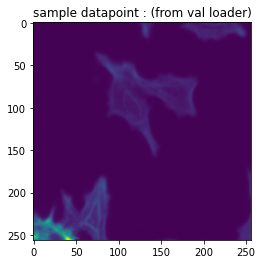

dataset value range :  0.007844130508601665 0.9450981616973877


In [8]:
trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= 100)
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= True, batch_size_valtest= 1)

In [9]:
import cv2
import util

In [ ]:
metric_ssim_temp = []
metric_psnr_temp = []

Xs, X_hats= [], []
for i, (x, y) in enumerate(val_loader):
    x= x.to(device)
    y= y.to(device)

    decoder_upsample_net.eval()
    decoder.eval()
    modelH.eval()

    with torch.no_grad():
        X= x.float()
        Ht= modelH(m)

        lambda_up, yt_down = modelA.compute_yt(X, Ht)
        yt_up = decoder_upsample_net(yt_down, Ht= Ht) + connect_forward_inverse(lambda_up, epoch)
        X_hat = decoder(yt_up, Ht= Ht) # Ht will be used if Ht should be updated through decoder, Therefore depend on the decoder architecture
    
        Xs.append(X.cpu().detach().numpy())
        X_hats.append(X_hat.cpu().detach().numpy())
    output = (X_hat[0,0].unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC
    img_gt = (X[0,0].unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC

    psnr = util.calculate_psnr(output, img_gt, crop_border=0)
    ssim = util.calculate_ssim(output, img_gt, crop_border=0)
    
    metric_psnr_temp.append(psnr)
    metric_ssim_temp.append(ssim)


In [50]:
print(f'PSNR  : {np.mean(metric_psnr_temp)}')
print(f'SSIM  : {np.mean(metric_ssim_temp)}')

# full val set (2112 images) results
#PSNR  : 40.24468293479473
#SSIM  : 0.9664120814733835

PSNR  : 40.103919386107584
SSIM  : 0.9654857413367938


In [52]:

gt = torch.from_numpy(np.array(Xs))[:,0]
pred = torch.from_numpy(np.array(X_hats))[:,0]

In [ ]:
import cv2


plt.figure(figsize= (14, 10))
plt.subplot(2,1,1)
grid_img1 = torchvision.utils.make_grid(gt[3:6], nrow=3)
plt.imshow(cv2.cvtColor(grid_img1.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('gt')
plt.xticks([])
plt.yticks([])
plt.show()


plt.figure(figsize= (14, 10))
plt.subplot(2,1,2)
grid_img2 = torchvision.utils.make_grid(pred[3:6], nrow=3)
plt.imshow(cv2.cvtColor(grid_img2.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('pred')
plt.xticks([])
plt.yticks([])
plt.savefig('fig3_noswinir.png', dpi= 300)
plt.show()

print('ssim : ', ssim_ignite(gt.float()/255.0, pred.float()/255.0))

In [10]:
import torchvision
transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Grayscale(1),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0,), (1,))])
            
def whole2patch(whole_img, H, W, img_size): #whole_img: (H, W), patch_imgs: (b, 1, img_size, img_size)
    patch_imgs = whole_img.reshape(H//img_size, img_size, W//img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).unsqueeze(dim=1)
    return patch_imgs

def patch2whole(patch_imgs, H, W, img_size): # patch_imgs: (b, 1, img_size, img_size)
    out_recon= patch_imgs[:,0].reshape(H//img_size, W//img_size, img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2)
    return out_recon

def pad_img(img, window_size, h_old, w_old): # input: img (A, B)
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img = torch.cat([img, torch.flip(img, [0])], 0)[:h_old + h_pad, :]
    img = torch.cat([img, torch.flip(img, [1])], 1)[:, :w_old + w_pad]

    return img

In [11]:
from PIL import Image

In [12]:
def get_preds_decoder(decoder_upsample_net, decoder, modelH, X):
    decoder_upsample_net.eval()
    decoder.eval()
    modelH.eval()

    with torch.no_grad():
        Ht= modelH(m)
        lambda_up, yt_down = modelA.compute_yt(X, Ht)
        yt_up = decoder_upsample_net(yt_down, Ht= Ht)
        X_hat = decoder(yt_up, Ht= Ht) # Ht will be used if Ht should be updated through decoder, Therefore depend on the decoder architecture
        
    return X_hat, Ht, yt_down


In [13]:
window_size= 256
img_size= 256

i=1
img_dir= '/home/udith/udith_works/superres_eval/large_cell_imgs/bbbcHumanMCF7cells_sample_large_imgs/57.png' #94.png
input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
H, W = input_img.shape
input_img_padded = pad_img(input_img, window_size, H, W)
H_new, W_new = input_img_padded.shape

X= whole2patch(input_img_padded, H_new, W_new, img_size)
X_hat, Ht, yt_down = get_preds_decoder(decoder_upsample_net, decoder, modelH, X)
X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
recon_img= recon_img_padded[:H, :W]


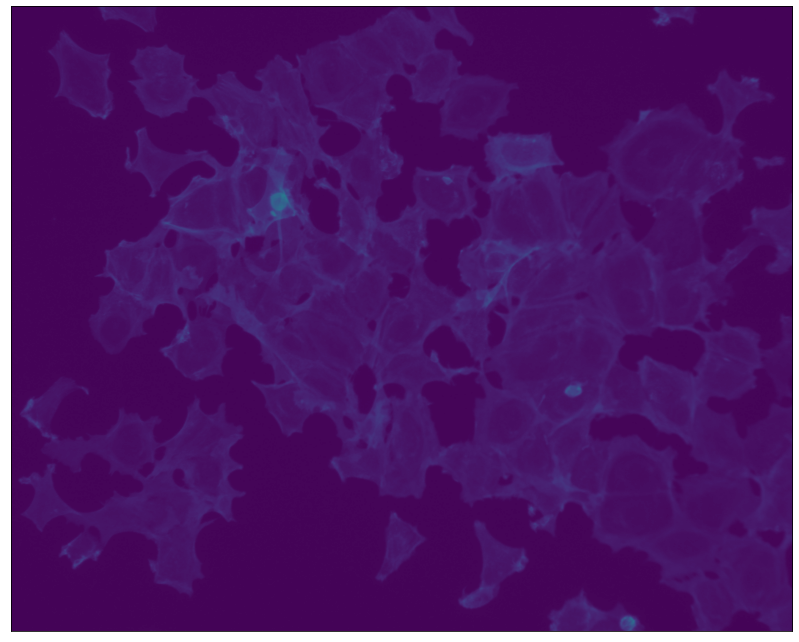

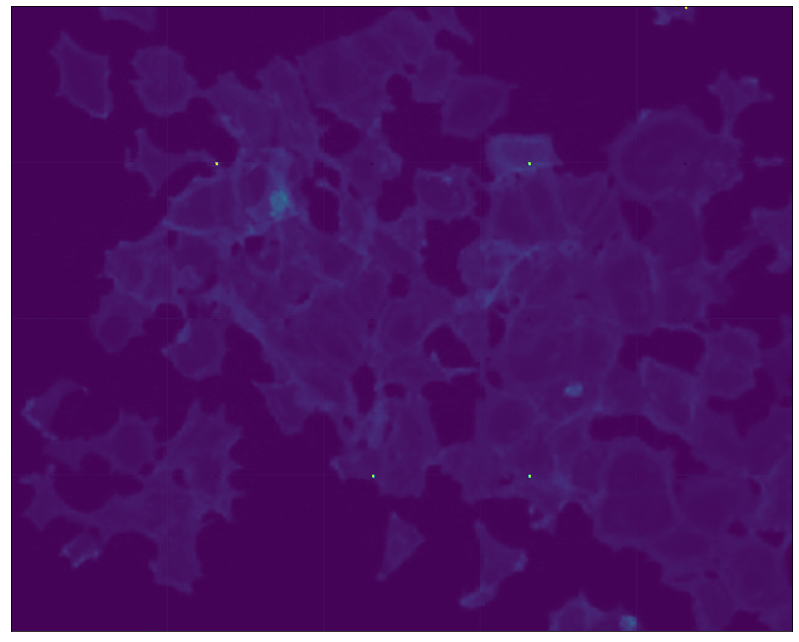

In [15]:

plt.figure(figsize= (14, 14))
plt.imshow(input_img, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.savefig(f'./{i}_cellSR_gt.png', dpi= 300)
plt.show()

plt.figure(figsize= (14, 14))
plt.imshow(recon_img, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.savefig(f'./{i}_cellSR_baseline.png', dpi= 300)
plt.show()
